We will experiment with the trained model

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
anime_ids = pd.read_csv("myanimedata/anime.csv", sep="\t")[["anime_id", "title"]]

In [3]:
anime_df = pd.read_csv("my_anime_data_cleaned/anime_data.csv")

In [4]:
anime_df = pd.concat([anime_ids, anime_df], axis=1)

In [5]:
anime_df.drop(columns=["anime_id"], inplace=True)

In [6]:
def find_index_title(titre:str, limit=5):
    candidats = anime_df[anime_df["title"].str.contains(titre, case=False)]
    return candidats[["anime_index", "title"]].iloc[:limit]

In [7]:
with open("scalers/item_scaler.pickle", "rb") as f :
    xm_scaler = pickle.load(f)
with open("scalers/label_scaler.pickle", "rb") as f :
    labelScaler = pickle.load(f)

In [104]:
def decaying_average(anime_indexes:list) -> np.ndarray :
    decay_rate = 0.95
    
    series_features = anime_df[anime_df["anime_index"].isin(anime_indexes)]
    series_features.drop(columns=["anime_index", "title"], inplace=True)
    if "cluster" in series_features.columns :
        series_features.drop(columns=["cluster"], inplace=True)

    series_features = series_features.to_numpy()

    series_features = xm_scaler.transform(series_features)
    
    num_series = series_features.shape[0]

    decay_factor = np.array([decay_rate**x for x in range(num_series)]).reshape(-1, 1)



    series_features *= decay_factor
    print("the shape is : ", series_features.shape)

    return np.mean(series_features, axis=0).reshape(1, -1)    

In [9]:
# import the model
from hybrid_filtering.hybrid_recommendation_system import Hybrid_recommendation_system
from hybrid_filtering.parameters_prediction import Params_prediction
from cluster_module.clustering import Cluster

2023-11-07 04:46:49.038715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 04:46:49.710029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
lr = 0.00005
model = Hybrid_recommendation_system(20, 20, 83, 83, lr=lr, l_d=128)
model.load_model()

2023-11-07 04:46:50.901823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


ncf loaded
content model loaded
all models loaded


In [11]:
user_params_predictor = Params_prediction(model.ncf.x_dim, lr, pred_type="user")
user_cluster = Cluster(model.ncf._user_params)

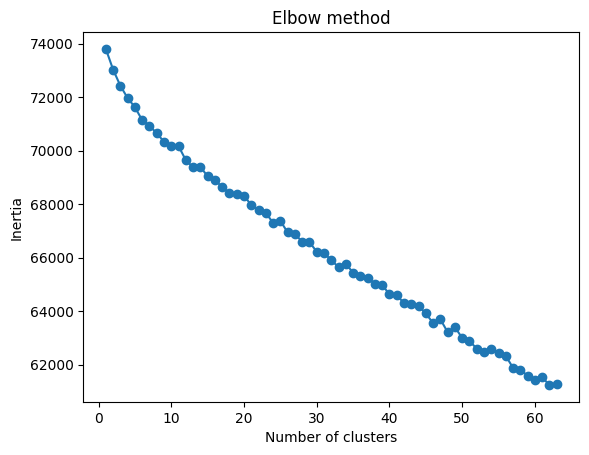

In [16]:
user_cluster.visualize_inertia(max_cluster=64)

In [12]:
user_cluster.clustering(48)
user_cluster.save_cluster("user_cluster")

In [108]:
def predict_user_params(user_feat):
    user_vec = model.predict_latent_vec(user_feat)
    user_params = user_params_predictor(user_vec)
    
    # find the cluster centroid 
    cluster, centroid = user_cluster.find_cluster(user_params.numpy(), use_distance=False)
    return cluster, centroid

Now making the prediction

In [14]:
movie_feat = pd.read_csv("my_anime_data_cleaned/anime_data.csv", sep=",")
movie_feat = movie_feat.iloc[:, 2:].to_numpy()
movie_feat = xm_scaler.transform(movie_feat)

movie_params = model.ncf._item_params

Search the title for the show to include in the list and then insert the indexes inside the index array

In [61]:
find_index_title("kimetsu")

,anime_index,title
635,635,Kimetsu no Yaiba: Katanakaji no Sato-hen
2406,2406,Kimetsu no Yaiba: Mugen Ressha-hen
2750,2750,Kimetsu no Yaiba: Yuukaku-hen
4272,4272,Kimetsu no Yaiba
6304,6304,Chuukou Ikkan!! Kimetsu Gakuen Monogatari: Val...


In [ ]:
index_array = [] # place the index of the input anime here

In [ ]:

user_feat = decaying_average(
    index_array
)

In [109]:
# preparing the user variables
user_feat = user_feat.reshape(1, -1)
clst, user_param = predict_user_params(user_feat)

array([34], dtype=int32)

In [110]:
# prediction
ratings_values = model.prediction(user_feat, movie_feat, user_param, movie_params, expand=True)

ratings = [0 for x in range(len(ratings_values))]
for i in range(len(ratings)) :
    ratings[i] = (i, ratings_values[i])

# sorting the prediction by rate
ratings = sorted(ratings, key=lambda x: x[1], reverse=True)

answer = [(x[0], labelScaler.inverse_transform(x[1].numpy().reshape(1, -1))) for x in ratings[:10]]
answer_index = [x[0] for x in answer] 

In [112]:
# displaying the predictions
anime_df[anime_df["anime_index"].isin(answer_index)]["title"]

798       Mushoku Tensei: Isekai Ittara Honki Dasu Part 2
1686                     Monogatari Series: Second Season
1995                               Yojouhan Shinwa Taikei
2304                           3-gatsu no Lion 2nd Season
2349                                          Steins;Gate
2659                               Hunter x Hunter (2011)
3479                  Gintama.: Shirogane no Tamashii-hen
7145                      Yozakura Quartet: Tsuki ni Naku
9101    Yahari Ore no Seishun Love Comedy wa Machigatt...
9125                                 Ginga Eiyuu Densetsu
Name: title, dtype: object

Creating movie clusters based on the learn model parameters

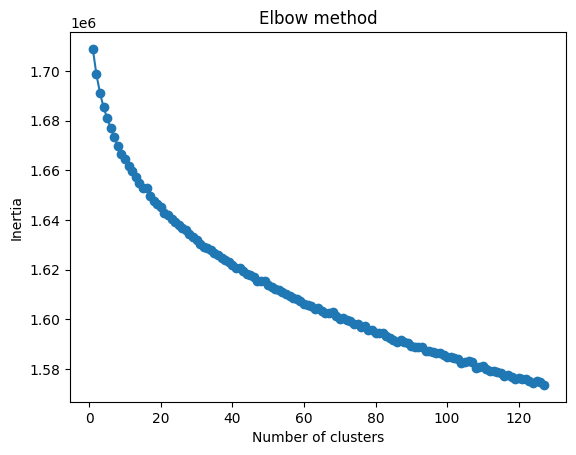

In [67]:
movie_cluster = Cluster(movie_params)
movie_cluster.visualize_inertia(max_cluster=128)

In [69]:
labels = movie_cluster.clustering(58)
movie_cluster.save_cluster("movie_cluster")

In [70]:
anime_df["cluster"] = labels

In [79]:
anime_df[anime_df["cluster"] == 12]["title"].iloc[:20]

1                       Sabaku no Kaizoku! Captain Kuppa
12     Dungeon ni Deai wo Motomeru no wa Machigatteir...
23                              Hyouga Senshi Gaislugger
100                                   Yowamushi Monsters
170                    Zhu Zhu Xia: Wu Ling Shou Wei Zhe
198                           Tonikaku Kawaii 2nd Season
216                           Hanasaka Tenshi Tenten-kun
283                                            Wansa-kun
303    Motto! Majime ni Fumajime Kaiketsu Zorori 2nd ...
384                                           Gene Diver
393                                   Dotanba no Manners
422                                Vinland Saga Season 2
429                       Buta no Liver wa Kanetsu Shiro
431                                Pururun! Shizuku-chan
437    Maou Gakuin no Futekigousha: Shijou Saikyou no...
439                                   Kimi to Fit Boxing
484               Akita Kenritsu Iburi Gakkou Chuutou-bu
485                            

In [113]:
model.ncf._user_params.shape

(573, 128)